In [ ]:
!pip install xmltodict
!pip install mtcnn

  Using cached https://files.pythonhosted.org/packages/28/fd/30d5c1d3ac29ce229f6bdc40bbc20b28f716e8b363140c26eff19122d8a5/xmltodict-0.12.0-py2.py3-none-any.whl
     |████████████████████████████████| 2.3MB 13.1MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import xmltodict
import random
from os import listdir
from os.path import isfile, join
import tensorflow as tf
import keras

Using TensorFlow backend.


In [ ]:
def getImageNames():
    image_names = []
    for dirname, _, filenames in os.walk('/content/drive/My Drive/Colab Notebooks/MaskvsNoMask_Dataset'):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            extension = fullpath[len(fullpath) - 4:]
            if extension != '.xml':
                image_names.append(filename)
    return image_names

In [ ]:
def get_path(image_name):
    
    home_path = '/content/drive/My Drive/Colab Notebooks/MaskvsNoMask_Dataset'
    image_path = home_path + '/images/' + image_name momh
    
    if image_name[-4:] == 'jpeg':
        label_name = image_name[:-5] + '.xml'
    else:
        label_name = image_name[:-4] + '.xml'
       
    label_path = home_path + '/labels/' + label_name
        
    return  image_path, label_path

In [ ]:
def parse_xml(label_path):
    
    
    
    x = xmltodict.parse(open(label_path , 'rb'))
    item_list = x['annotation']['object']
    
    # when image has only one bounding box
    if not isinstance(item_list, list):
        item_list = [item_list]
        
    result = []
    
    for item in item_list:
        name = item['name']
        bndbox = [(int(item['bndbox']['xmin']), int(item['bndbox']['ymin'])),
                  (int(item['bndbox']['xmax']), int(item['bndbox']['ymax']))]       
        result.append((name, bndbox))
    
    size = [int(x['annotation']['size']['width']), 
            int(x['annotation']['size']['height'])]
    
    return result, size

In [ ]:
def visualize_image(image_name, bndbox=True):
    
    image_path, label_path = get_path(image_name)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if bndbox:
        labels, size = parse_xml(label_path)
        thickness = int(sum(size)/400.)
        
        for label in labels:
            name, bndbox = label
            
            if name == 'good':
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 255, 0), thickness)
            elif name == 'bad':
                cv2.rectangle(image, bndbox[0], bndbox[1], (255, 0, 0), thickness)
            else: # name == 'none'
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 0, 255), thickness)
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(image_name)
    plt.imshow(image)
    plt.show()

In [ ]:
image_names = getImageNames()

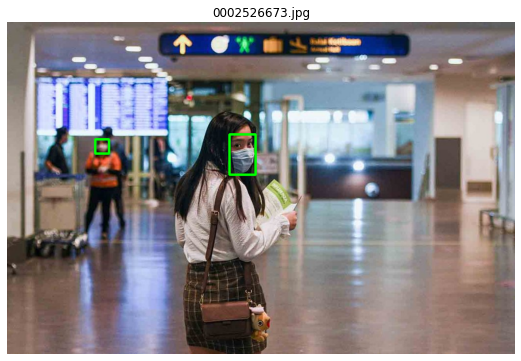

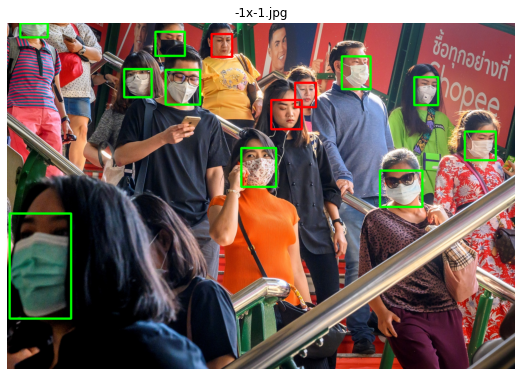

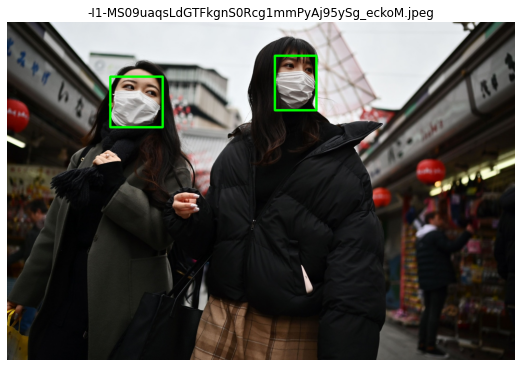

In [ ]:
NUM_OF_IMGS_TO_VISUALIZE = 3

for i in range(NUM_OF_IMGS_TO_VISUALIZE):
    visualize_image(image_names[i])

In [ ]:
def cropImage(image_name):
    image_path, label_path = get_path(image_name)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    
    labels, size = parse_xml(label_path)
    
    cropedImgLabels = []

    for label in labels:
        name, bndbox = label
        
        
        croped_image = image[bndbox[0][1]:bndbox[1][1], bndbox[0][0]:bndbox[1][0]]
        
        label_num = 0
        
        if name == "good":
            label_num = 0
        elif name == "bad":
            label_num = 1
        else:
            label_num = 2
        
        cropedImgLabel = [croped_image, label_num]
        
        cropedImgLabels.append(cropedImgLabel)
        
    return cropedImgLabels

In [ ]:
def createDirectory(dirname):
    try:
        os.mkdir(dirname)
    except FileExistsError:
        print("Directory " + dirname + " already exists.")

In [ ]:
dir_name = 'train/'
label_0_dir = dir_name + "0/"
label_1_dir = dir_name + "1/"
#label_2_dir = dir_name + "2/"
models_dir = "models/"


createDirectory(dir_name)
createDirectory(label_0_dir)
createDirectory(label_1_dir)
#createDirectory(label_2_dir)
createDirectory(models_dir)

In [ ]:
label_0_counter = 0
label_1_counter = 0
#label_2_counter = 0

for image_name in image_names:
    cropedImgLabels = cropImage(image_name)
    
    for cropedImgLabel in cropedImgLabels:
        
        label = cropedImgLabel[1]
        img = cropedImgLabel[0]
        
        if label == 0:
            croped_img_name = str(label_0_counter) + ".jpg"
            cv2.imwrite(label_0_dir + croped_img_name, img)
            label_0_counter += 1
        elif label == 1:
            croped_img_name = str(label_1_counter) + ".jpg"
            cv2.imwrite(label_1_dir + croped_img_name, img)
            label_1_counter += 1
        #else:
            #croped_img_name = str(label_2_counter) + ".jpg"
            #cv2.imwrite(label_2_dir + croped_img_name, img)
            #label_2_counter += 1

In [ ]:
filenames_label_0 = [f for f in listdir(label_0_dir) if isfile(join(label_0_dir, f))]
filenames_label_1 = [f for f in listdir(label_1_dir) if isfile(join(label_1_dir, f))]
#onlyfiles_2 = [f for f in listdir(label_2_dir) if isfile(join(label_2_dir, f))]

In [ ]:
print("Total number of images: " + str(len(filenames_label_0) + len(filenames_label_1)))
print("Number of images labeled 0: " + str(len(filenames_label_0)))
print("Number of images labeled 1: " + str(len(filenames_label_1)))
#print("Number of images labeled 2: " + str(len(onlyfiles_2)))

Total number of images: 3788
Number of images labeled 0: 3121
Number of images labeled 1: 667


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import xmltodict
import random
from os import listdir
from os.path import isfile, join
import torchvision 
import torch 
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
for layer, param in model.named_parameters():
    
    if 'layer4' not in layer:
        param.requires_grad = False

model.fc = torch.nn.Sequential(torch.nn.Linear(2048, 512),
                                 torch.nn.ReLU(),
                                 torch.nn.Dropout(0.2),
                                 torch.nn.Linear(512, 2),
                                 torch.nn.LogSoftmax(dim=1))

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

In [ ]:
dataset = datasets.ImageFolder(dir_name, transform = train_transforms)

dataset_size = len(dataset)
train_size = int(dataset_size * 0.6)
val_size = int(dataset_size * 0.2)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

print('Dataset size: ', len(dataset))
print('Train set size: ', len(train_dataset))
print('Validation set size: ', len(val_dataset))
print('Test set size: ', len(test_dataset))

Dataset size:  3788
Train set size:  2272
Validation set size:  757
Test set size:  759


In [ ]:
BATCH_SIZE = 20

train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

In [ ]:
LEARNING_RATE = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
total_epoch = 10

best_epoch = 0
training_losses = []
val_losses = []


for epoch in range(total_epoch):
    
    epoch_train_loss = 0
    
    for X, y in train_loader:
        
        X, y = X.cuda(), y.cuda()
        
        optimizer.zero_grad()
        result = model(X)
        loss = criterion(result, y)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
      
    training_losses.append(epoch_train_loss)
    
    epoch_val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X, y in val_loader:
            
            X, y = X.cuda(), y.cuda()
             
            result = model(X)
            loss = criterion(result, y)
            epoch_val_loss += loss.item()
            _, maximum = torch.max(result.data, 1)
            total += y.size(0)
            correct += (maximum == y).sum().item()
            
    val_losses.append(epoch_val_loss)
    accuracy = correct/total
    print("EPOCH:", epoch, ", Training Loss:", epoch_train_loss, ", Validation Loss:", epoch_val_loss, ", Accuracy: ", accuracy)

    if min(val_losses) == val_losses[-1]:
       best_epoch = epoch
       checkpoint = {'model': model,
                  'state_dict': model.state_dict(),
                  'optimizer' : optimizer.state_dict()}

    torch.save(checkpoint, models_dir + '{}.pth'.format(epoch))
    print("Model saved")

EPOCH: 0 , Training Loss: 19.48152011493221 , Validation Loss: 3.9642885625362396 , Accuracy:  0.9630118890356671
Model saved
EPOCH: 1 , Training Loss: 6.26470341851018 , Validation Loss: 2.97170075912436 , Accuracy:  0.9709379128137384
Model saved
EPOCH: 2 , Training Loss: 4.131735697446857 , Validation Loss: 3.271478228387423 , Accuracy:  0.9682959048877147
Model saved
EPOCH: 3 , Training Loss: 2.7508293940336443 , Validation Loss: 4.448328821454197 , Accuracy:  0.964332892998679
Model saved
EPOCH: 4 , Training Loss: 3.4432175454712706 , Validation Loss: 3.5117747133772355 , Accuracy:  0.9762219286657859
Model saved
EPOCH: 5 , Training Loss: 1.8092110272464197 , Validation Loss: 2.4554331542476575 , Accuracy:  0.9815059445178336
Model saved
EPOCH: 6 , Training Loss: 1.820912244160354 , Validation Loss: 3.760742219456006 , Accuracy:  0.9762219286657859
Model saved
EPOCH: 7 , Training Loss: 1.739084164201131 , Validation Loss: 3.303640569894924 , Accuracy:  0.9801849405548216
Model sav

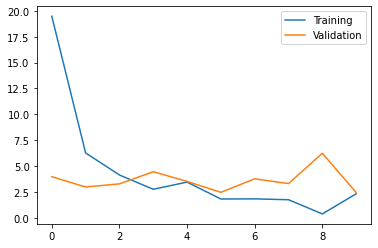

In [ ]:
plt.plot(range(total_epoch), training_losses, label='Training')
plt.plot(range(total_epoch), val_losses, label='Validation')
plt.legend()

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    return model.eval()


filepath = models_dir + str(best_epoch) + ".pth"
loaded_model = load_checkpoint(filepath)

train_transforms = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

In [ ]:
correct = 0
total = 0
import time 
import numpy as np  
i = 0
diff = []
with torch.no_grad():
    for X, y in test_loader:
        start = time.time()
        X, y = X.cuda(), y.cuda()

        result = loaded_model(X)
        end = time.time()
        diff = np.append(diff, (end - start))
        i = i + 1
        _, maximum = torch.max(result.data, 1)
        total += y.size(0)
        correct += (maximum == y).sum().item()
diff = (np.sum(np.array(diff))/diff.shape[0])*1000
print(str(diff)+"ms")
accuracy = correct/total

print("\n")
print("------------")
print("Accuracy: " + str(accuracy))
print("------------")
print("\n")

9.086470854909797ms


------------
Accuracy: 0.9920948616600791
------------




In [ ]:
from PIL import Image

cap = cv2.VideoCapture(0)

font_scale=1
thickness = 2
red = (0,0,255)
green = (0,255,0)
blue = (255,0,0)
font=cv2.FONT_HERSHEY_SIMPLEX

from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mtcnn.mtcnn import MTCNN



while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        detector = MTCNN()
        faces = detector.detect_faces(frame)
        
        for result in faces:
            x, y, w, h = result['box']
            cv2.rectangle(frame, (x, y), (x+w, y+h), blue, 2)
            
            croped_img = frame[y:y+h, x:x+w]
            pil_image = Image.fromarray(croped_img, mode = "RGB")
            pil_image = train_transforms(pil_image)
            image = pil_image.unsqueeze(0)
            
            
            result = loaded_model(image)
            _, maximum = torch.max(result.data, 1)
            prediction = maximum.item()

            
            if prediction == 0:
                cv2.putText(frame, "Masked", (x,y - 10), font, font_scale, green, thickness)
                cv2.rectangle(frame, (x, y), (x+w, y+h), green, 2)
            elif prediction == 1:
                cv2.putText(frame, "No Mask", (x,y - 10), font, font_scale, red, thickness)
                cv2.rectangle(frame, (x, y), (x+w, y+h), red, 2)
        
        from google.colab.patches import cv2_imshow        
        cv2_imshow(frame)
        
        if (cv2.waitKey(1) & 0xFF) == ord('q'):
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

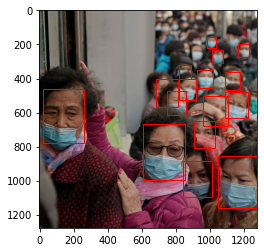

In [ ]:
# face detection with mtcnn on a photograph
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mtcnn.mtcnn import MTCNN

# draw an image with detected objects
def draw_image_with_boxes(filename, result_list):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for result in result_list:
		# get coordinates
		x, y, width, height = result['box']
		# create the shape
		rect = Rectangle((x, y), width, height, fill=False, color='red')
		# draw the box
		ax.add_patch(rect)
	# show the plot
	pyplot.show()


filepath = 'Test_Image7.jpg'
# load image from file
pixels = pyplot.imread(filepath)
# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
faces = detector.detect_faces(pixels)
# display faces on the original image
draw_image_with_boxes(filepath, faces)

1052.9074668884277
{'box': [817, 405, 100, 119], 'confidence': 0.9999502897262573, 'keypoints': {'left_eye': (863, 448), 'right_eye': (904, 456), 'nose': (886, 482), 'mouth_left': (850, 495), 'mouth_right': (882, 502)}}
{'box': [923, 349, 95, 104], 'confidence': 0.9999270439147949, 'keypoints': {'left_eye': (961, 389), 'right_eye': (1004, 388), 'nose': (986, 409), 'mouth_left': (966, 428), 'mouth_right': (1001, 427)}}
{'box': [607, 670, 250, 325], 'confidence': 0.9998663663864136, 'keypoints': {'left_eye': (686, 811), 'right_eye': (799, 815), 'nose': (741, 880), 'mouth_left': (693, 935), 'mouth_right': (786, 936)}}
{'box': [1093, 364, 83, 106], 'confidence': 0.9996743202209473, 'keypoints': {'left_eye': (1125, 404), 'right_eye': (1161, 407), 'nose': (1145, 427), 'mouth_left': (1127, 445), 'mouth_right': (1158, 448)}}
{'box': [748, 471, 114, 142], 'confidence': 0.9995276927947998, 'keypoints': {'left_eye': (805, 531), 'right_eye': (851, 530), 'nose': (840, 556), 'mouth_left': (808, 581)

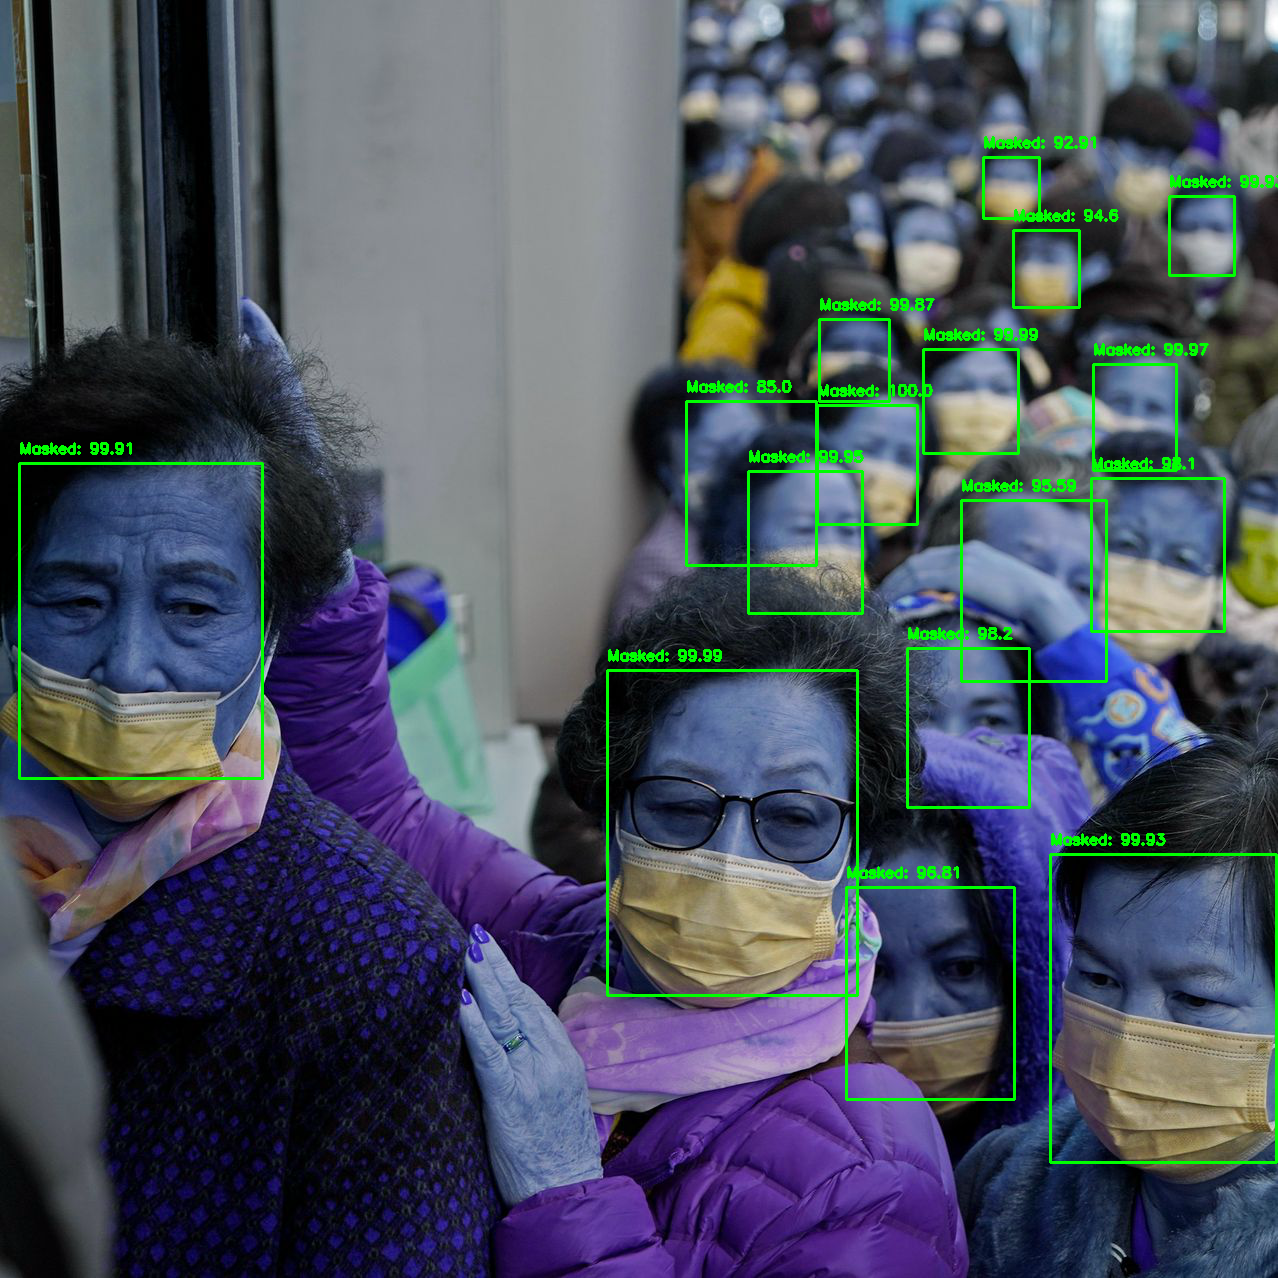

44201.02904577157ms


In [ ]:

font_scale=0.5
thickness = 2
red = (0,0,255)
green = (0,255,0)
blue = (255,0,0)
font=cv2.FONT_HERSHEY_SIMPLEX
start1 = time.time() 
filepath = 'Test_Image7.jpg'
pixels = pyplot.imread(filepath)
# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
faces = detector.detect_faces(pixels)

end1 = time.time()
diff1 = end1 - start1
print(diff1*1000)
for result in faces:
           
            print(result)
            start = time.time()
            x, y, w, h = result['box']
            cv2.rectangle(img, (x, y), (x+w, y+h), blue, 2)
            confidence = str(np.round(100 * result['confidence'],2))
            croped_img = pixels[y:y+h, x:x+w]
            pil_image = Image.fromarray(croped_img, mode = "RGB")
            pil_image = train_transforms(pil_image)
            image = pil_image.unsqueeze(0)
            
            image = image.cuda()
            
            result = loaded_model(image)
            _, maximum = torch.max(result.data, 1)
            prediction = maximum.item()
            

            
            if prediction == 0:
                cv2.putText(pixels, "Masked: " + confidence, (x,y - 10), font, font_scale, green, thickness)
                cv2.rectangle(pixels, (x, y), (x+w, y+h), green, 2)
            elif prediction == 1:
                cv2.putText(pixels, "No Mask: " + str(confidence), (x,y - 10), font, font_scale, red, thickness)
                cv2.rectangle(pixels, (x, y), (x+w, y+h), red, 2)
            end = time.time()
            diff = np.append(diff, (end - start))

#pixels = cv2.cvtColor(pixels, cv2.COLOR_RGB2BGR)
from google.colab.patches import cv2_imshow        
cv2_imshow(pixels)
diff = (np.sum(np.array(diff))/diff.shape[0])*1000
print(str(diff)+"ms")